In [1]:
import os
import numpy as np
import pandas as pd
import scorecardpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# try:
#     from scorecardpipeline.utils import *
#     from scorecardpipeline.processing import *
#     from scorecardpipeline.model import *
# except ModuleNotFoundError:
import sys

sys.path.append("../")
from scorecardpipeline.utils import *
from scorecardpipeline.processing import *
from scorecardpipeline.model import *

(CVXPY) May 23 06:18:26 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 23 06:18:26 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
init_setting(seed=10, font_path="/Users/lubberit/Desktop/workspace/scorecardpipeline/scorecardpipeline/matplot_chinese.ttf")

In [3]:
target = "creditability"
data = sc.germancredit()
data[target] = data[target].map({"good": 0, "bad": 1})

train, test = train_test_split(data, test_size=0.3, shuffle=True, stratify=data[target])

In [4]:
feature_pipeline = Pipeline([
    ("preprocessing_select", FeatureSelection(target=target, engine="scorecardpy")),
    ("combiner", Combiner(target=target, min_bin_size=0.2)),
    ("transform", WOETransformer(target=target)),
    ("processing_select", FeatureSelection(target=target, engine="toad")),
    ("stepwise", StepwiseSelection(target=target)),
])

feature_pipeline.fit(train)

woe_train = feature_pipeline.transform(train)
woe_test = feature_pipeline.transform(test)

[INFO] filtering variables ...


In [5]:
logistic = ITLubberLogisticRegression(target=target)
logistic.fit(woe_train)

ITLubberLogisticRegression(target='creditability')

In [6]:
y_pred_train = logistic.predict_proba(woe_train.drop(columns=target))[:, 1]
y_pred_test = logistic.predict_proba(woe_test.drop(columns=target))[:, 1]

In [7]:
print("train: ", toad.metrics.KS(y_pred_train, train[target]), toad.metrics.AUC(y_pred_train, train[target]))
print("test: ", toad.metrics.KS(y_pred_test, test[target]), toad.metrics.AUC(y_pred_test, test[target]))

train:  0.5428571428571428 0.8339844509232264
test:  0.44285714285714284 0.7657142857142857


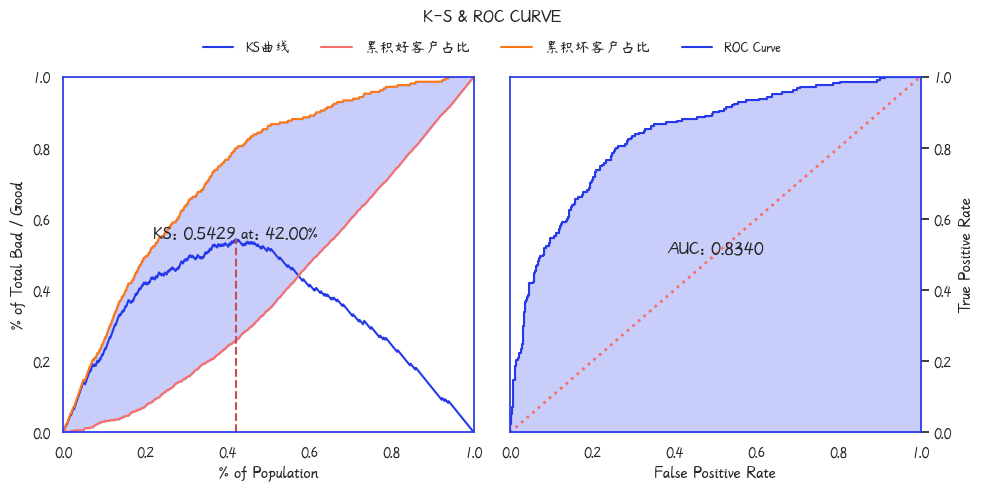

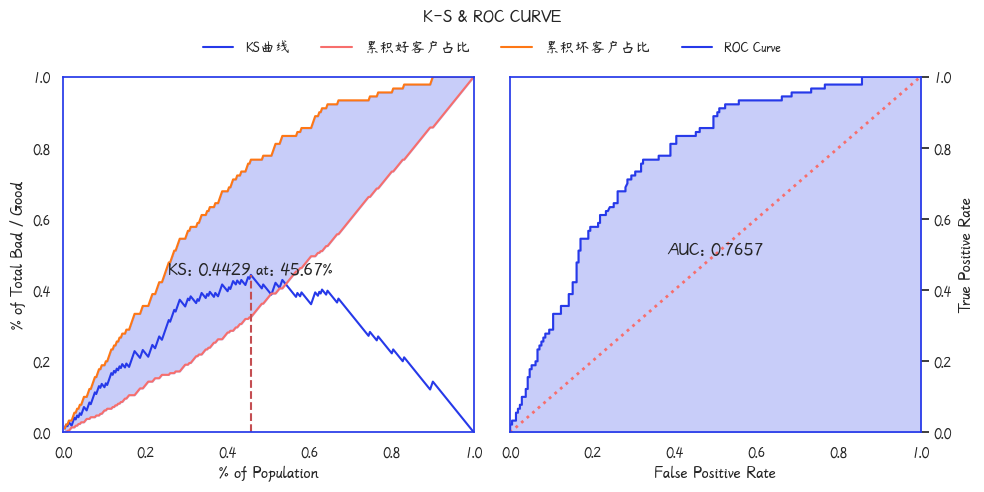

In [8]:
_ = ks_plot(y_pred_train, train[target], figsize=(10, 5))
_ = ks_plot(y_pred_test, test[target], figsize=(10, 5))

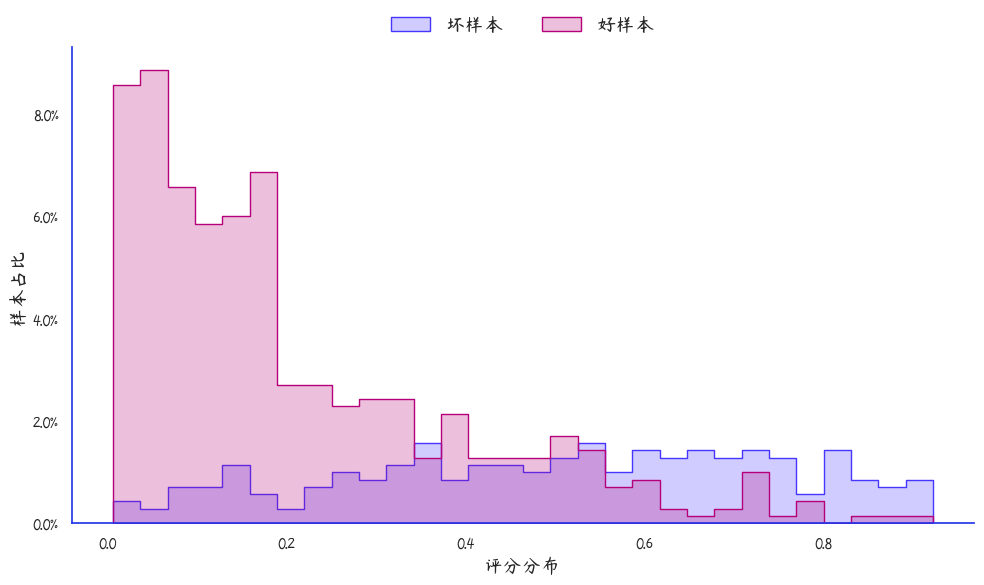

In [9]:
_ = score_hist(y_pred_train, train[target], figsize=(10, 6))

In [10]:
logistic.summary()

,Coef.,Std.Err,z,P>|z|,[ 0.025,0.975 ],VIF
const,-0.8448,0.0997,-8.4760,0.0000,-1.0402,-0.6495,1.0579
age.in.years,0.8550,0.3165,2.7014,0.0069,0.2347,1.4754,1.0529
credit.history,0.7360,0.1768,4.1620,0.0000,0.3894,1.0825,1.0741
savings.account.and.bonds,0.8334,0.2118,3.9351,0.0001,0.4183,1.2485,1.0753
credit.amount,1.0240,0.3108,3.2947,0.0010,0.4148,1.6331,1.2106
housing,0.5324,0.3161,1.6841,0.0922,-0.0872,1.1520,1.0396
installment.rate.in.percentage.of.disposable.income,1.3444,0.4969,2.7054,0.0068,0.3704,2.3184,1.0943
purpose,0.9620,0.2788,3.4509,0.0006,0.4156,1.5083,1.0268
personal.status.and.sex,0.8773,0.5516,1.5906,0.1117,-0.2037,1.9584,1.0184
present.employment.since,1.0008,0.3189,3.1386,0.0017,0.3758,1.6258,1.0189


In [11]:
logistic.report(woe_train)

,desc,precision,recall,f1-score,support
0,好客户,0.8228,0.9000,0.8596,490.0000
1,坏客户,0.7012,0.5476,0.6150,210.0000
2,macro avg,0.7620,0.7238,0.7373,700.0000
3,weighted avg,0.7863,0.7943,0.7862,700.0000
4,accuracy,,,0.7943,700.0000


<Axes: >

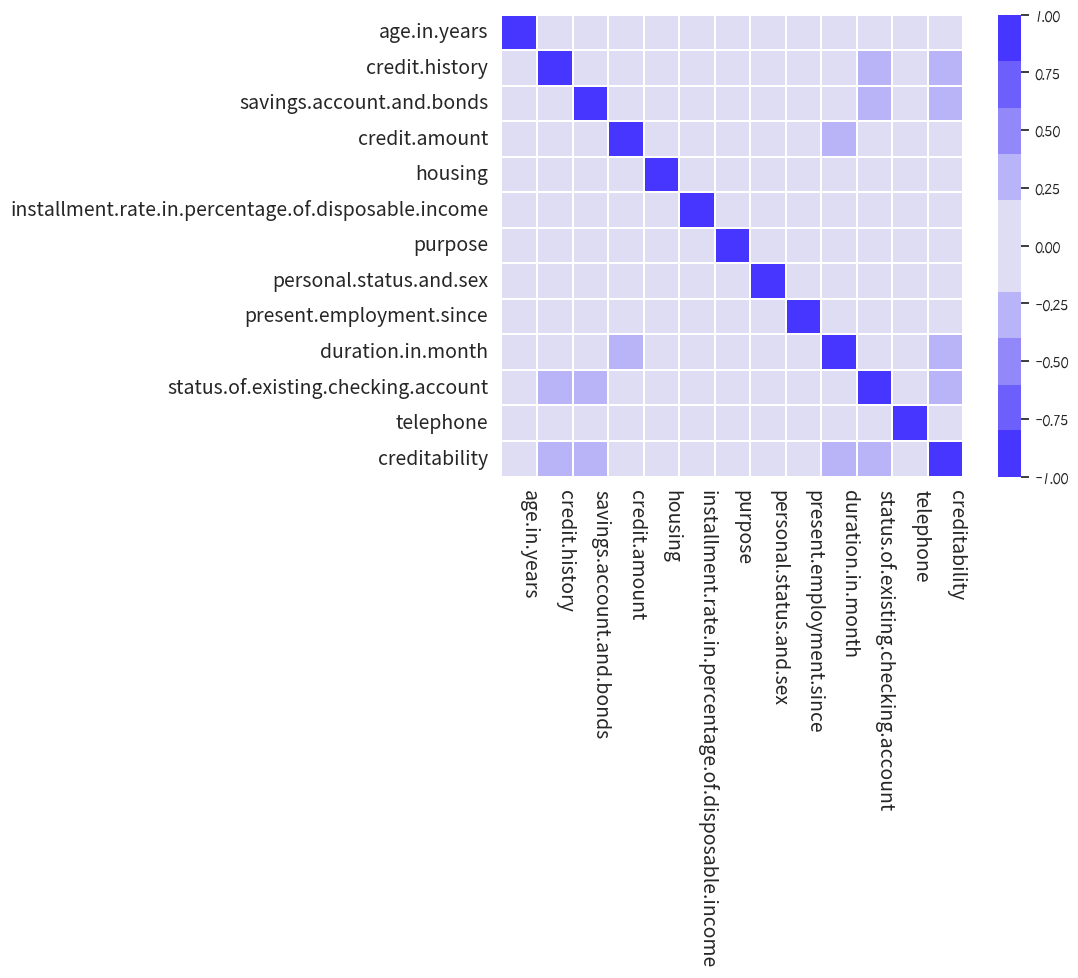

In [12]:
corr_plot(woe_train, annot=False, figure_size=(9, 6))

In [13]:
card = ScoreCard(target=target, pipeline=feature_pipeline, pretrain_lr=logistic)
card.fit(woe_train)

ScoreCard(combiner=<toad.transform.Combiner object at 0x7fde409cc430>,
          pipeline=Pipeline(steps=[('preprocessing_select',
                                    FeatureSelection(target='creditability')),
                                   ('combiner',
                                    Combiner(min_bin_size=0.2,
                                             rules={'age.in.years': array([26, 45]),
                                                    'credit.amount': array([1845, 3914]),
                                                    'credit.history': array([list(['critical account/ other credits existing (not at this bank)...
                                             target='creditability')),
                                   ('transform',
                                    WOETransformer(exclude=[],
                                                   target='creditability')),
                                   ('processing_select',
                                    FeatureSelection(engine='toad',
                                                     target='creditability')),
                                   ('stepwise',
                                    StepwiseSelection(target='creditability'))]),
          pretrain_lr=ITLubberLogisticRegression(target='creditability'),
          target='creditability',
          transer=<toad.transform.WOETransformer object at 0x7fde409cc550>)

In [14]:
train["score"] = card.predict(train)
test["score"] = card.predict(test)

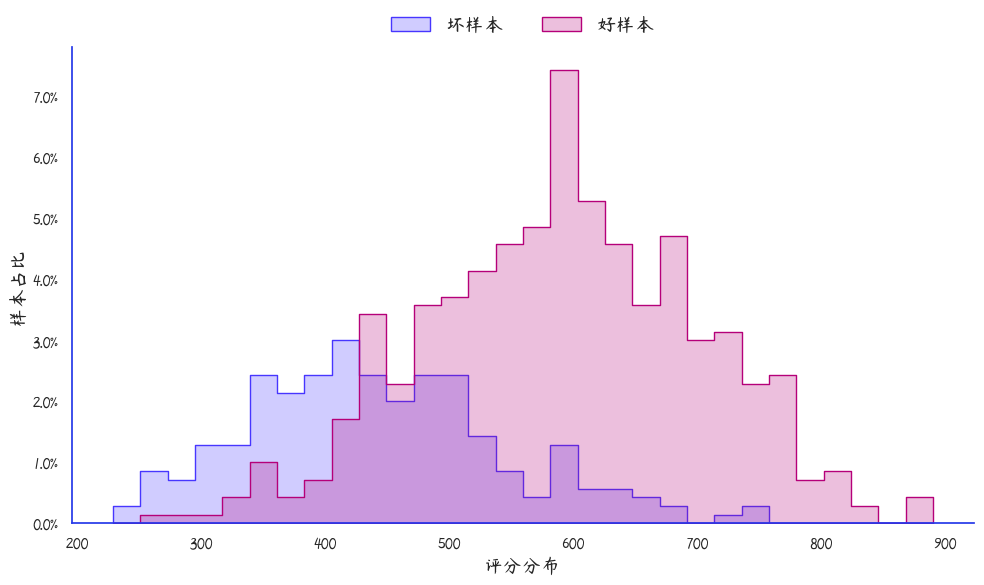

In [16]:
_ = score_hist(train["score"], train[target], figsize=(10, 6))

In [17]:
feature_describe = pd.DataFrame([
    ["status_account", "支票账户状态"], ["duration", "借款周期"], ["credit_histor", "历史信用"], ["purpose", "借款目的"], ["amount", "信用额度"], ["svaing_account", "储蓄账户状态"], ["present_emp", "当前就业状态"], ["income_rate", "分期付款占可支配收入百分比"], ["personal_status", "性别与婚姻状态"], ["other_debtors", "他人担保信息"], ["residence_info", "现居住地"], ["property", "财产状态"], ["age", "年龄"], ["inst_plans", "其他分期情况"], ["housing", "房产状态"], ["num_credits", "信用卡数量"], ["job", "工作状态"], ["dependents", "赡养人数"], ["telephone", "电话号码注册情况"], ["foreign_worke", "是否有海外工作经历"],
], columns=["变量名称", "变量含义"])
feature_map = dict(zip(feature_describe["变量名称"], feature_describe["变量含义"]))

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,age.in.years,逻辑回归入模变量,"[负无穷 , 26)",190,0.1900,110,0.1571,80,0.2667,0.4211,-0.5288,0.0579,0.0767,1.4035,1.4035,110,80,0.1095
1,age.in.years,逻辑回归入模变量,"[26 , 45)",609,0.6090,439,0.6271,170,0.5667,0.2791,0.1014,0.0061,0.0767,0.9305,1.0430,549,250,0.0490
2,age.in.years,逻辑回归入模变量,"[45 , 正无穷)",201,0.2010,151,0.2157,50,0.1667,0.2488,0.2580,0.0127,0.0767,0.8292,1.0000,700,300,0.0000


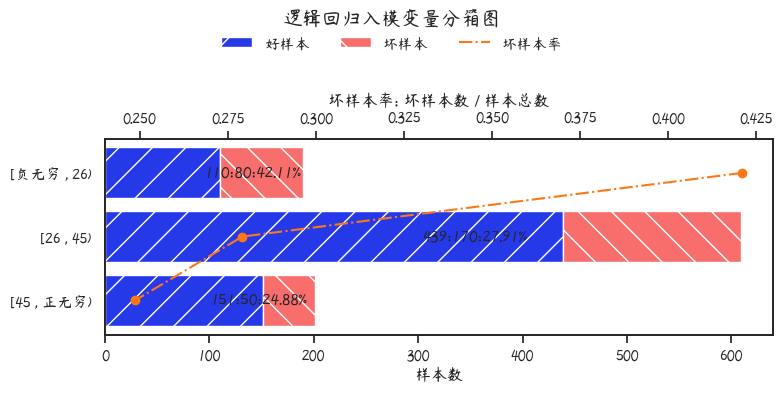

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,credit.history,逻辑回归入模变量,critical account/ other credits existing (not at this bank),293,0.2930,243,0.3471,50,0.1667,0.1706,0.7337,0.1324,0.2918,0.5688,0.5688,243,50,-0.1805
1,credit.history,逻辑回归入模变量,"existing credits paid back duly till now,delay in paying off in the past",618,0.6180,421,0.6014,197,0.6567,0.3188,-0.0879,0.0049,0.2918,1.0626,0.9038,664,247,-0.1252
2,credit.history,逻辑回归入模变量,"all credits at this bank paid back duly,no credits taken/ all credits paid back duly",89,0.0890,36,0.0514,53,0.1767,0.5955,-1.2341,0.1546,0.2918,1.9850,1.0000,700,300,0.0000


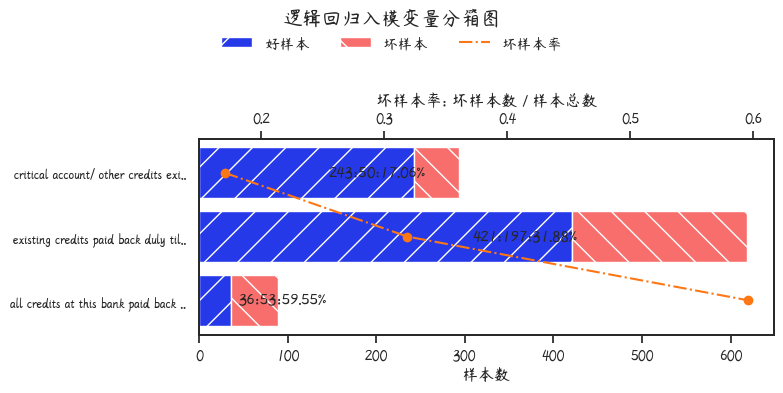

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,savings.account.and.bonds,逻辑回归入模变量,"... >= 1000 DM,500 <= ... < 1000 DM,unknown/ no savings account",294,0.2940,245,0.3500,49,0.1633,0.1667,0.7621,0.1423,0.1910,0.5556,0.5556,245,49,-0.1867
1,savings.account.and.bonds,逻辑回归入模变量,100 <= ... < 500 DM,103,0.1030,69,0.0986,34,0.1133,0.3301,-0.1396,0.0021,0.1910,1.1003,0.6969,314,83,-0.1719
2,savings.account.and.bonds,逻辑回归入模变量,... < 100 DM,603,0.6030,386,0.5514,217,0.7233,0.3599,-0.2714,0.0466,0.1910,1.1996,1.0000,700,300,0.0000


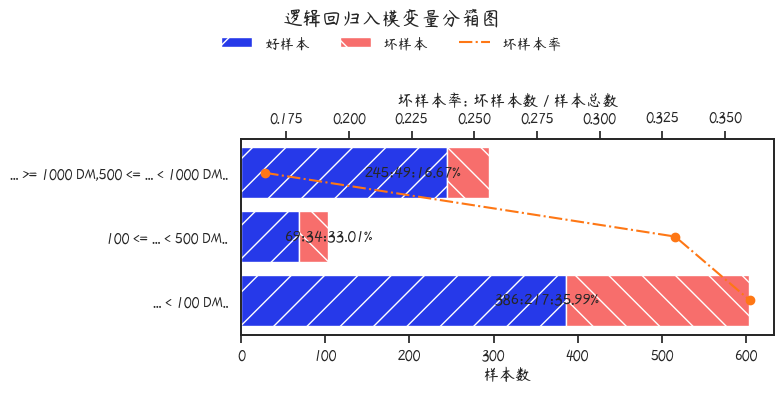

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,credit.amount,逻辑回归入模变量,"[负无穷 , 1845)",383,0.3830,277,0.3957,106,0.3533,0.2768,0.1133,0.0048,0.1315,0.9225,0.9225,277,106,-0.0424
1,credit.amount,逻辑回归入模变量,"[1845 , 3914)",357,0.3570,274,0.3914,83,0.2767,0.2325,0.3470,0.0398,0.1315,0.7750,0.8514,551,189,-0.1571
2,credit.amount,逻辑回归入模变量,"[3914 , 正无穷)",260,0.2600,149,0.2129,111,0.3700,0.4269,-0.5529,0.0869,0.1315,1.4231,1.0000,700,300,0.0000


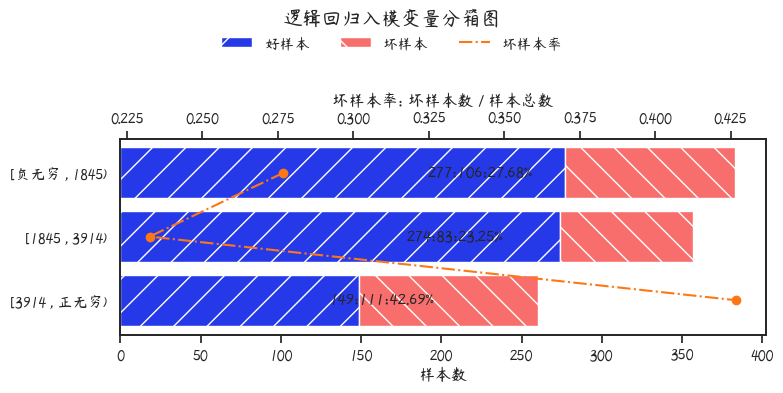

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,housing,房产状态,own,713,0.7130,527,0.7529,186,0.6200,0.2609,0.1942,0.0258,0.0833,0.8696,0.8696,527,186,-0.1329
1,housing,房产状态,rent,179,0.1790,109,0.1557,70,0.2333,0.3911,-0.4044,0.0314,0.0833,1.3035,0.9567,636,256,-0.0552
2,housing,房产状态,for free,108,0.1080,64,0.0914,44,0.1467,0.4074,-0.4726,0.0261,0.0833,1.3580,1.0000,700,300,0.0000


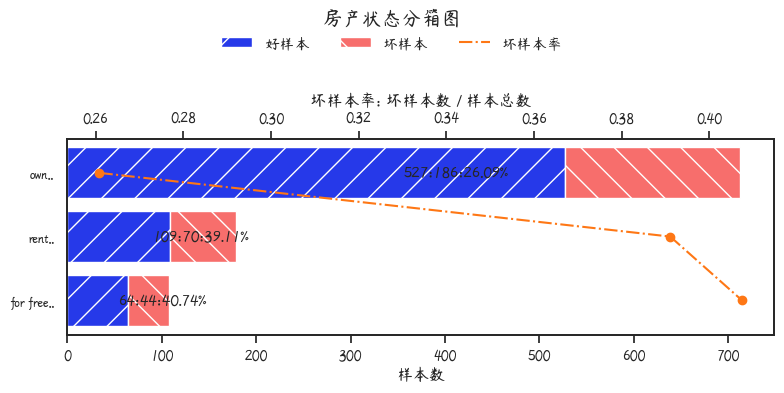

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,installment.rate.in.percentage.of.disposable.income,逻辑回归入模变量,"[负无穷 , 2)",136,0.1360,102,0.1457,34,0.1133,0.2500,0.2513,0.0081,0.0256,0.8333,0.8333,102,34,-0.0324
1,installment.rate.in.percentage.of.disposable.income,逻辑回归入模变量,"[2 , 4)",388,0.3880,281,0.4014,107,0.3567,0.2758,0.1182,0.0053,0.0256,0.9192,0.8969,383,141,-0.0771
2,installment.rate.in.percentage.of.disposable.income,逻辑回归入模变量,"[4 , 正无穷)",476,0.4760,317,0.4529,159,0.5300,0.3340,-0.1573,0.0121,0.0256,1.1134,1.0000,700,300,0.0000


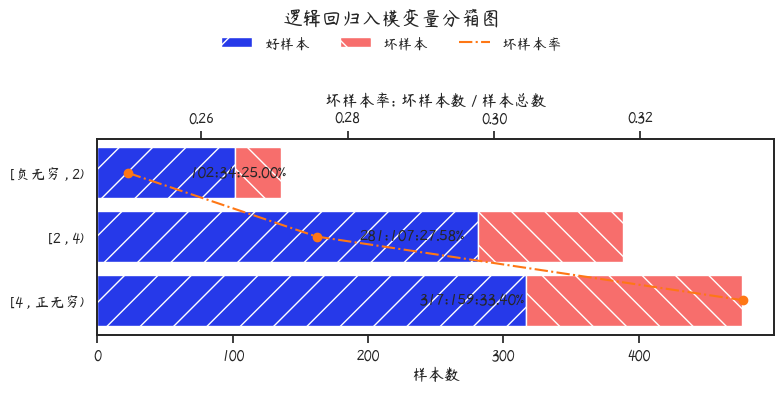

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,purpose,借款目的,"car (used),retraining,radio/television,domestic appliances",404,0.4040,320,0.4571,84,0.2800,0.2079,0.4902,0.0868,0.1470,0.6931,0.6931,320,84,-0.1771
1,purpose,借款目的,"repairs,business,furniture/equipment",300,0.3000,200,0.2857,100,0.3333,0.3333,-0.1542,0.0073,0.1470,1.1111,0.8712,520,184,-0.1295
2,purpose,借款目的,"education,car (new),others",296,0.2960,180,0.2571,116,0.3867,0.3919,-0.4079,0.0528,0.1470,1.3063,1.0000,700,300,0.0000


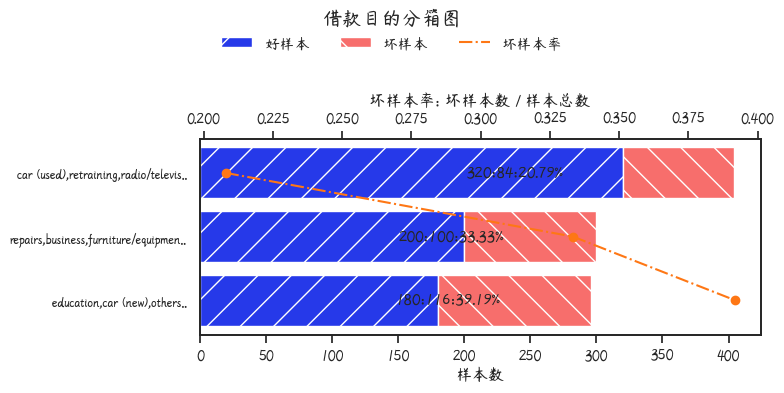

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,personal.status.and.sex,逻辑回归入模变量,"male : divorced/separated,female : divorced/separated/married",360,0.3600,259,0.3700,101,0.3367,0.2806,0.0944,0.0031,0.0064,0.9352,0.9352,259,101,-0.0333
1,personal.status.and.sex,逻辑回归入模变量,male : single,548,0.5480,380,0.5429,168,0.5600,0.3066,-0.0311,0.0005,0.0064,1.0219,0.9875,639,269,-0.0162
2,personal.status.and.sex,逻辑回归入模变量,male : married/widowed,92,0.0920,61,0.0871,31,0.1033,0.3370,-0.1704,0.0028,0.0064,1.1232,1.0000,700,300,0.0000


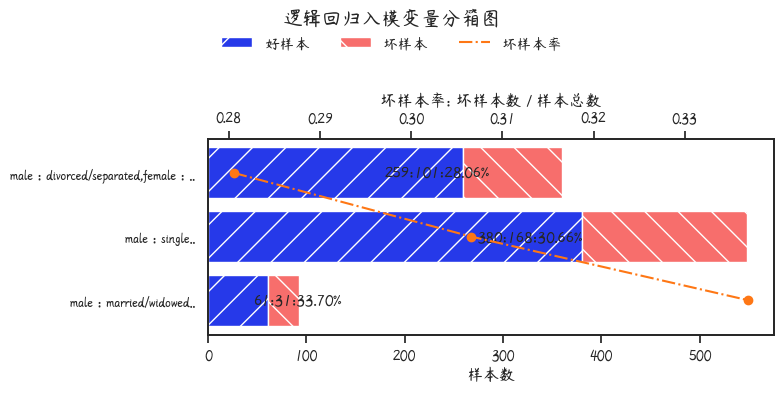

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,present.employment.since,逻辑回归入模变量,4 <= ... < 7 years,174,0.1740,135,0.1929,39,0.1300,0.2241,0.3944,0.0248,0.0752,0.7471,0.7471,135,39,-0.0629
1,present.employment.since,逻辑回归入模变量,"1 <= ... < 4 years,... >= 7 years",592,0.5920,424,0.6057,168,0.5600,0.2838,0.0785,0.0036,0.0752,0.9459,0.9008,559,207,-0.1086
2,present.employment.since,逻辑回归入模变量,"unemployed,... < 1 year",234,0.2340,141,0.2014,93,0.3100,0.3974,-0.4311,0.0468,0.0752,1.3248,1.0000,700,300,0.0000


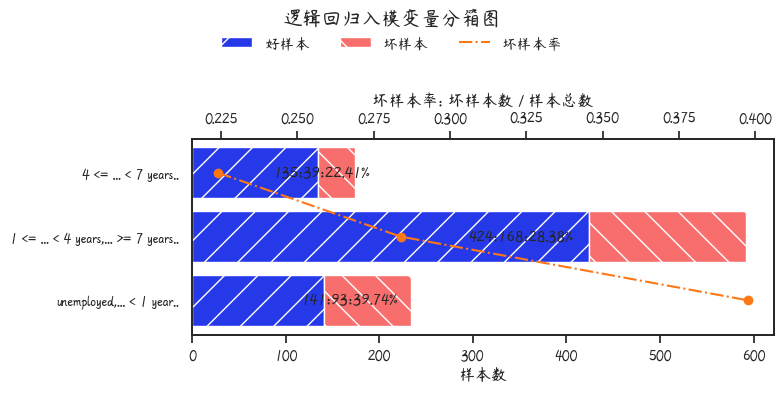

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,duration.in.month,逻辑回归入模变量,"[负无穷 , 12)",180,0.1800,153,0.2186,27,0.0900,0.1500,0.8873,0.1141,0.2152,0.5000,0.5000,153,27,-0.1286
1,duration.in.month,逻辑回归入模变量,"[12 , 27)",591,0.5910,420,0.6000,171,0.5700,0.2893,0.0513,0.0015,0.2152,0.9645,0.8560,573,198,-0.1586
2,duration.in.month,逻辑回归入模变量,"[27 , 正无穷)",229,0.2290,127,0.1814,102,0.3400,0.4454,-0.6281,0.0996,0.2152,1.4847,1.0000,700,300,0.0000


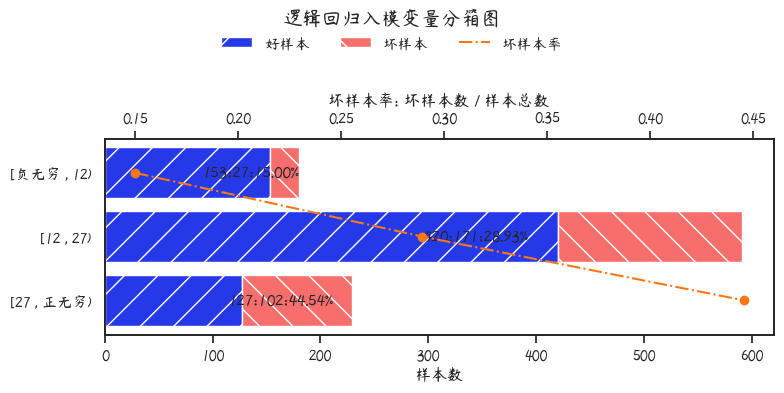

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,status.of.existing.checking.account,逻辑回归入模变量,"... >= 200 DM / salary assignments for at least 1 year,no checking account",457,0.4570,397,0.5671,60,0.2000,0.1313,1.0423,0.3827,0.6348,0.4376,0.4376,397,60,-0.3671
1,status.of.existing.checking.account,逻辑回归入模变量,0 <= ... < 200 DM,269,0.2690,164,0.2343,105,0.3500,0.3903,-0.4014,0.0464,0.6348,1.3011,0.7576,561,165,-0.2514
2,status.of.existing.checking.account,逻辑回归入模变量,... < 0 DM,274,0.2740,139,0.1986,135,0.4500,0.4927,-0.8181,0.2057,0.6348,1.6423,1.0000,700,300,0.0000


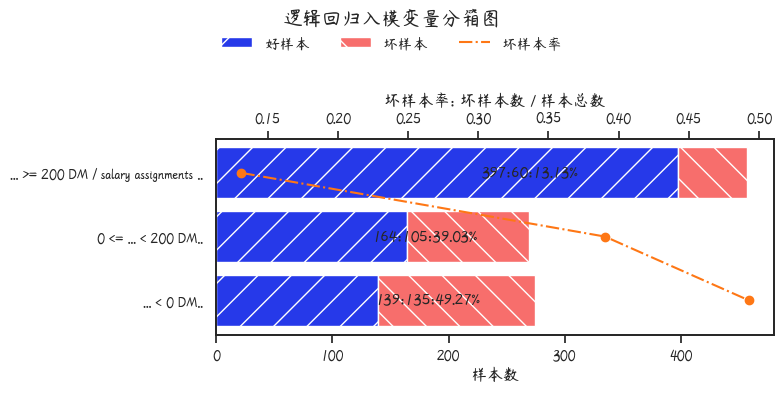

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,telephone,电话号码注册情况,"yes, registered under the customers name",404,0.4040,291,0.4157,113,0.3767,0.2797,0.0986,0.0039,0.0064,0.9323,0.9323,291,113,-0.0390
1,telephone,电话号码注册情况,none,596,0.5960,409,0.5843,187,0.6233,0.3138,-0.0647,0.0025,0.0064,1.0459,1.0000,700,300,0.0000


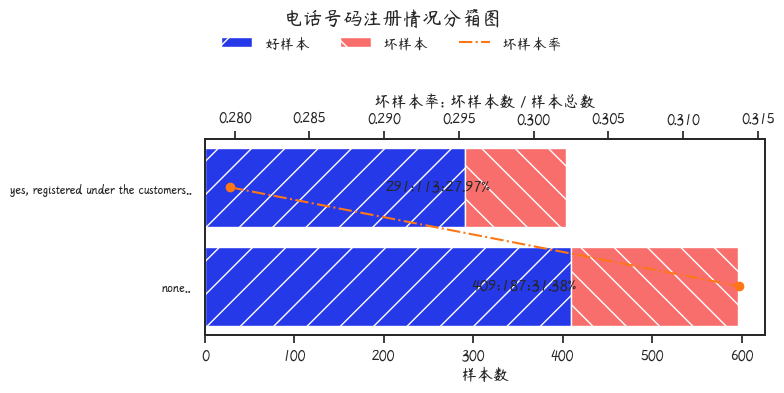

In [18]:
for col in card.rules.keys():
    feature_table = feature_bin_stats(data, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=card.combiner)
    # plot_dataframe(feature_table)
    display(feature_table)
    _ = bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4))
    plt.show()

In [ ]:
import math
import re


writer = ExcelWriter(style_excel="./utils/报告输出模版.xlsx", theme_color="8E8BFE")


# ////////////////////////////////////// 样本说明 ///////////////////////////////////// #
df = pd.DataFrame({
    "date": pd.date_range(start="2021-01-01", end="2022-06-30"),
    "target": np.random.randint(0, 2, 546),
    "count": np.random.randint(0, 100, 546),
})

total_count = len(data)
dataset_summary = pd.DataFrame(
    [
        ["建模样本", "2022-01-01", "2023-01-31", len(data), len(data) / total_count, data[target].sum(), data[target].sum() / len(data), ""],
        ["训练集", "2022-01-01", "2023-12-31", len(train), len(train) / total_count, train[target].sum(), train[target].sum() / len(train), ""],
        ["测试集", "2022-01-01", "2023-12-31", len(test), len(test) / total_count, test[target].sum(), test[target].sum() / len(test), ""],
        ["跨时间验证集", "2023-01-01", "2023-01-31", len(oot), len(oot) / total_count, oot[target].sum(), oot[target].sum() / len(oot), ""],
    ],
    columns=["数据集", "开始时间", "结束时间", "样本总数", "样本占比", "坏客户数", "坏客户占比", "备注"],
)

worksheet = writer.get_sheet_by_name("汇总信息")

# 样本总体分布情况
start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="样本总体分布情况", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, dataset_summary, (end_row + 1, start_col), header=True)

writer.set_number_format(worksheet, f"{get_column_letter(end_col - 2)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 2)}{end_row}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(end_col - 4)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 4)}{end_row}", "0.00%")

# 建模样本时间分布情况
temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/all_sample_time_count.png")
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="建模样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/all_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

# 训练集样本时间分布情况
temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/train_sample_time_count.png")
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练集样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

# 测试集样本时间分布情况
temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/test_sample_time_count.png")
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试集样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

# 跨时间验证集样本时间分布情况
temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/oot_sample_time_count.png")
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/oot_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")


# ////////////////////////////////////// 模型报告 ///////////////////////////////////// #

# 逻辑回归拟合情况
worksheet = writer.get_sheet_by_name("逻辑回归拟合结果")
start_row, start_col = 2, 2

end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="逻辑回归拟合效果", style="header")
# worksheet.merge_cells(f"{get_column_letter(start_col)}{start_row}:{get_column_letter(start_col + len(summary.columns) - 1)}{start_row}")
# worksheet[f"{get_column_letter(start_col)}{start_row}:{get_column_letter(start_col + len(summary.columns) - 1)}{start_row}"].style = "header"
logistic.plot_weights(save="model_report/logistic_train.png")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/logistic_train.png", (end_row + 2, start_col))
end_row, end_col = writer.insert_df2sheet(worksheet, summary, (end_row + 1, start_col))

conditional_column = get_column_letter(start_col + summary.columns.get_loc("Coef."))
writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(summary)}', f'{conditional_column}{end_row}')

# worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(train_report.columns) - 1)}{end_row + 2}")
# worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集拟合报告", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_train.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = writer.insert_df2sheet(worksheet, train_report, (end_row + 1, start_col))

# worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(test_report.columns) - 1)}{end_row + 2}")
# worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集拟合报告", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_test.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = writer.insert_df2sheet(worksheet, test_report, (end_row + 1, start_col))

# worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(oot_report.columns) - 1)}{end_row + 2}")
# worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集拟合报告", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_oot.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = writer.insert_df2sheet(worksheet, oot_report, (end_row + 1, start_col))


# ////////////////////////////////////// 特征概述 ///////////////////////////////////// #

# 模型变量概览
feature_describe = pd.DataFrame([
    ["status_account", "支票账户状态"], ["duration", "借款周期"], ["credit_histor", "历史信用"], ["purpose", "借款目的"], ["amount", "信用额度"], ["svaing_account", "储蓄账户状态"], ["present_emp", "当前就业状态"], ["income_rate", "分期付款占可支配收入百分比"], ["personal_status", "性别与婚姻状态"], ["other_debtors", "他人担保信息"], ["residence_info", "现居住地"], ["property", "财产状态"], ["age", "年龄"], ["inst_plans", "其他分期情况"], ["housing", "房产状态"], ["num_credits", "信用卡数量"], ["job", "工作状态"], ["dependents", "赡养人数"], ["telephone", "电话号码注册情况"], ["foreign_worke", "是否有海外工作经历"],
], columns=["变量名称", "变量含义"])

worksheet = writer.get_sheet_by_name("模型变量信息")
start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量信息", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, feature_describe.reset_index().rename(columns={"index": "序号"}), (end_row + 1, start_col))

# 变量分布情况
data_info = toad.detect(data[card.rules.keys()]).reset_index().rename(columns={"index": "变量名称", "type": "变量类型", "size": "样本个数", "missing": "缺失值", "unique": "唯一值个数"})
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分布情况", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, data_info, (end_row + 1, start_col))

# 变量相关性
data_corr = logistic.corr(feature_pipeline.transform(train), save="model_report/data_corr.png", annot=False)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量相关性", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/data_corr.png", (end_row + 1, start_col), figsize=(700, 500))
end_row, end_col = writer.insert_df2sheet(worksheet, data_corr.reset_index().rename(columns={"index": ""}), (end_row + 1, start_col))

conditional_column = f"{get_column_letter(start_col + 1)}{end_row - len(data_corr)}:{get_column_letter(end_col - 1)}{end_row - 1}"
worksheet.conditional_formatting.add(conditional_column, ColorScaleRule(start_type='num', start_value=-1.0, start_color='8E8BFE', mid_type='num', mid_value=0., mid_color='FFFFFF', end_type='num', end_value=1.0, end_color='8E8BFE'))


# 变量分箱信息
_combiner = feature_pipeline.named_steps["combiner"]

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分箱信息", style="header")
for col in card.rules.keys():
    feature_table = card.feature_bin_stats(data, col, target=target, desc="逻辑回归入模变量", combiner=card.combiner)
    # _combiner.bin_plot(data, col, labels=True, save=f"model_report/bin_plots/data_{col}.png")
    bin_plot(feature_table, feature=col, save=f"model_report/bin_plots/data_{col}.png")
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/bin_plots/data_{col}.png", (end_row + 1, start_col), figsize=(700, 400))
    end_row, end_col = writer.insert_df2sheet(worksheet, feature_table, (end_row, start_col))

    for c in ["坏样本率", "LIFT值"]:
        conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
        writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(feature_table)}', f'{conditional_column}{end_row}')
        # conditional_column = get_column_letter(start_col + feature_table.columns.get_loc("LIFT值"))
        # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(feature_table)}', f'{conditional_column}{end_row}')

    for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值"]:
        conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
        writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(feature_table)}:{conditional_column}{end_row}", "0.00%")


# ////////////////////////////////////// 评分卡说明 ///////////////////////////////////// #

# 评分卡刻度
scorecard_kedu = pd.DataFrame(
    [
        ["base_odds", card.base_odds, "根据业务经验设置的基础比率（违约概率/正常概率），估算方法：（1-样本坏客户占比）/坏客户占比"],
        ["base_score", card.base_score, "基础ODDS对应的分数"],
        ["rate", card.rate, "设置分数的倍率"],
        ["pdo", card.pdo, "表示分数增长PDO时，ODDS值增长到RATE倍"],
        ["B", card.offset, "补偿值，计算方式：pdo / ln(rate)"],
        ["A", card.factor, "刻度，计算方式：base_score - B * ln(base_odds)"],
    ],
    columns=["刻度项", "刻度值", "备注"],
)

worksheet = writer.get_sheet_by_name("评分卡结果")
start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="评分卡刻度", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_kedu, (end_row + 1, start_col))

# 评分卡对应分数
card_points = card.export(to_frame=True).rename(columns={"name": "变量名称", "value": "变量分箱", "score": "对应分数"})
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡分数", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, card_points, (end_row + 1, start_col), merge_column="变量名称")

# 评分效果
clip = 50
clip_start = max(math.ceil(train["score"].min() / clip) * clip, math.ceil(train["score"].quantile(0.01) / clip) * clip)
clip_end = min(math.ceil(train["score"].max() / clip) * clip, math.ceil(train["score"].quantile(0.99) / clip) * clip)
score_clip = [i for i in range(clip_start, clip_end, clip)]

train_score_rank = card.feature_bin_stats(train, "score", target=target, rules=score_clip, verbose=0, method="step", ks=True)
test_score_rank = card.feature_bin_stats(test, "score", target=target, rules=score_clip, verbose=0, method="step", ks=True)
oot_score_rank = card.feature_bin_stats(oot, "score", target=target, rules=score_clip, verbose=0, method="step", ks=True)

card.ks_plot(train["score"], train[target], title="Train Dataset", save="model_report/train_ksplot.png")
card.ks_plot(test["score"], test[target], title="Test Dataset", save="model_report/test_ksplot.png")
card.ks_plot(oot["score"], oot[target], title="OOT Dataset", save="model_report/oot_ksplot.png")

card.score_hist(train["score"], train[target], save="model_report/train_scorehist.png", bins=30, figsize=(13, 10))
card.score_hist(test["score"], test[target], save="model_report/test_scorehist.png", bins=30, figsize=(13, 10))
card.score_hist(oot["score"], oot[target], save="model_report/oot_scorehist.png", bins=30, figsize=(13, 10))


end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_scorehist.png", (ks_row, end_col))
end_row, end_col = writer.insert_df2sheet(worksheet, train_score_rank, (end_row + 1, start_col))

for c in ["坏样本率", "LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc(c))
    writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(train_score_rank)}', f'{conditional_column}{end_row}')

for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_score_rank)}:{conditional_column}{end_row}", "0.00%")

# conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc("坏样本率"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_score_rank)}', f'{conditional_column}{end_row}')
# conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc("LIFT值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_score_rank)}', f'{conditional_column}{end_row}')
# conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc("分档KS值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_score_rank)}', f'{conditional_column}{end_row}')


end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_scorehist.png", (ks_row, end_col))
end_row, end_col = writer.insert_df2sheet(worksheet, test_score_rank, (end_row + 1, start_col))

for c in ["坏样本率", "LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc(c))
    writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(test_score_rank)}', f'{conditional_column}{end_row}')

for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(test_score_rank)}:{conditional_column}{end_row}", "0.00%")

# conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc("坏样本率"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_score_rank)}', f'{conditional_column}{end_row}')
# conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc("LIFT值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_score_rank)}', f'{conditional_column}{end_row}')
# conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc("分档KS值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_score_rank)}', f'{conditional_column}{end_row}')


end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/oot_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/oot_scorehist.png", (ks_row, end_col))
end_row, end_col = writer.insert_df2sheet(worksheet, oot_score_rank, (end_row + 1, start_col))

for c in ["坏样本率", "LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc(c))
    writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(oot_score_rank)}', f'{conditional_column}{end_row}')

for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(oot_score_rank)}:{conditional_column}{end_row}", "0.00%")

# conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc("坏样本率"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(oot_score_rank)}', f'{conditional_column}{end_row}')
# conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc("LIFT值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(oot_score_rank)}', f'{conditional_column}{end_row}')
# conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc("分档KS值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(oot_score_rank)}', f'{conditional_column}{end_row}')


def score_psi(expected, actual, labels=["预期", "实际"], save=None, colors=['#8E8BFE', '#FEA3A2', '#9394E7'], figsize=(15, 8)):
    expected = expected.rename(columns={"分箱": "评分区间", "样本总数": f"{labels[0]}样本数", "样本占比": f"{labels[0]}样本占比", "坏样本率": f"{labels[0]}坏样本率"})
    actual = actual.rename(columns={"分箱": "评分区间", "样本总数": f"{labels[1]}样本数", "样本占比": f"{labels[1]}样本占比", "坏样本率": f"{labels[1]}坏样本率"})
    df_psi = expected.merge(actual, on="评分区间", how="outer").replace(np.nan, 0)
    df_psi[f"{labels[1]}% - {labels[0]}%"] = df_psi[f"{labels[1]}样本占比"] - df_psi[f"{labels[0]}样本占比"]
    df_psi[f"ln({labels[1]}% / {labels[0]}%)"] = np.log(df_psi[f"{labels[1]}样本占比"] / df_psi[f"{labels[0]}样本占比"])
    df_psi["分档PSI值"] = (df_psi[f"{labels[1]}% - {labels[0]}%"] * df_psi[f"ln({labels[1]}% / {labels[0]}%)"])
    df_psi = df_psi.fillna(0).replace(np.inf, 0).replace(-np.inf, 0)
    df_psi["总体PSI值"] = df_psi["分档PSI值"].sum()

    if save:
        if os.path.dirname(save) and not os.path.exists(os.path.dirname(save)):
            os.makedirs(os.path.dirname(save))

        x = df_psi['评分区间']
        width = 0.35
        x_indexes = np.arange(len(x))
        fig, ax1 = plt.subplots(figsize=figsize)

        ax1.bar(x_indexes - width / 2, df_psi[f'{labels[0]}样本占比'], width, label=f'{labels[0]}样本占比', color=colors[0], hatch="/")
        ax1.bar(x_indexes + width / 2, df_psi[f'{labels[1]}样本占比'], width, label=f'{labels[1]}样本占比', color=colors[1], hatch="\\")

        ax1.set_ylabel('样本占比: 评分区间内样本数 / 样本总数')
        ax1.set_xticks(x_indexes)
        ax1.set_xticklabels(x)
        ax1.tick_params(axis='x', labelrotation=90)

        ax2 = ax1.twinx()
        ax2.plot(df_psi["评分区间"], df_psi[f"{labels[0]}坏样本率"], color=colors[0], label=f"{labels[0]}坏样本率", linestyle=(5, (10, 3)))
        ax2.plot(df_psi["评分区间"], df_psi[f"{labels[1]}坏样本率"], color=colors[1], label=f"{labels[1]}坏样本率", linestyle=(5, (10, 3)))

        ax2.scatter(df_psi["评分区间"], df_psi[f"{labels[0]}坏样本率"], marker=".")
        ax2.scatter(df_psi["评分区间"], df_psi[f"{labels[1]}坏样本率"], marker=".")

        ax2.set_ylabel('坏样本率: 坏样本数 / 样本总数')

        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        fig.legend(handles1 + handles2, labels1 + labels2, loc='upper center', ncol=len(labels1 + labels2), bbox_to_anchor=(0.5, 0.94), frameon=False)

        fig.suptitle(f"{labels[0]} vs {labels[1]} 群体稳定性指数(PSI): {df_psi['分档PSI值'].sum():.4f}\n\n")

        fig.tight_layout()

        fig.savefig(save, dpi=240, format="png", bbox_inches="tight")

    return df_psi[["评分区间", f"{labels[0]}样本数", f"{labels[0]}样本占比", f"{labels[0]}坏样本率", f"{labels[1]}样本数", f"{labels[1]}样本占比", f"{labels[1]}坏样本率", f"{labels[1]}% - {labels[0]}%", f"ln({labels[1]}% / {labels[0]}%)", "分档PSI值", "总体PSI值"]]


train_test_score_psi = score_psi(train_score_rank, test_score_rank, labels=["训练数据集", "测试数据集"], save="model_report/train_test_psiplot.png")
train_oot_score_psi = score_psi(train_score_rank, oot_score_rank, labels=["训练数据集", "跨时间验证集"], save="model_report/train_oot_psiplot.png")
test_oot_score_psi = score_psi(test_score_rank, oot_score_rank, labels=["测试数据集", "跨时间验证集"], save="model_report/test_oot_psiplot.png")


end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡模型稳定性评估: 训练数据集 vs 测试数据集", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_test_psiplot.png", (end_row, start_col), figsize=(1000, 400))
end_row, end_col = writer.insert_df2sheet(worksheet, train_test_score_psi, (end_row + 1, start_col))

conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc("分档PSI值"))
writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_test_score_psi)}', f'{conditional_column}{end_row}')

for c in ["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"]:
    conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_test_score_psi)}:{conditional_column}{end_row}", "0.00%")


end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡模型稳定性评估: 训练数据集 vs 跨时间验证集", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_oot_psiplot.png", (end_row, start_col), figsize=(1000, 400))
end_row, end_col = writer.insert_df2sheet(worksheet, train_oot_score_psi, (end_row + 1, start_col))

conditional_column = get_column_letter(start_col + train_oot_score_psi.columns.get_loc("分档PSI值"))
writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_oot_score_psi)}', f'{conditional_column}{end_row}')

for c in ["训练数据集样本占比", "训练数据集坏样本率", "跨时间验证集样本占比", "跨时间验证集坏样本率"]:
    conditional_column = get_column_letter(start_col + train_oot_score_psi.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_oot_score_psi)}:{conditional_column}{end_row}", "0.00%")


end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡模型稳定性评估: 测试数据集 vs 跨时间验证集", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_oot_psiplot.png", (end_row, start_col), figsize=(1000, 400))
end_row, end_col = writer.insert_df2sheet(worksheet, test_oot_score_psi, (end_row + 1, start_col))

conditional_column = get_column_letter(start_col + test_oot_score_psi.columns.get_loc("分档PSI值"))
writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_oot_score_psi)}', f'{conditional_column}{end_row}')

for c in ["跨时间验证集样本占比", "跨时间验证集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"]:
    conditional_column = get_column_letter(start_col + test_oot_score_psi.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(test_oot_score_psi)}:{conditional_column}{end_row}", "0.00%")


# ////////////////////////////////////// 模型稳定性 ///////////////////////////////////// #
#
# worksheet = writer.get_sheet_by_name("模型稳定性")
# start_row, start_col = 2, 2
#
# # 变量 CSI 表
# end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量稳定性指标 (Characteristic Stability Index, CSI)", style="header")
#
# # train vs test
#
# # 评分分布稳定性
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="模型评分稳定性指标 (Population Stability Index, PSI)", style="header")


writer.save("model_report/评分卡模型报告.xlsx")